# How has U.S. Political Language Evolved Over Time? Is the Political Spectrum Clustering Towards the Extremes?

In [32]:
# === SETUP ===

# standard libraries
from pathlib import Path
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import json

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# paths
REPO_DIR = Path(".").resolve().parents[0]
DATA = REPO_DIR / "data"
FINDINGS = REPO_DIR / "results" / "final_findings"
FIGURES = FINDINGS / "figures"
FINDINGS.mkdir(parents=True, exist_ok=True)
FIGURES.mkdir(parents=True, exist_ok=True)
DEBATES = DATA / "debates_full.csv"
MEDIA = DATA / "media_balanced.csv"

# color palette
with open(Path(REPO_DIR / "color_palette_config.json")) as f:
    palette = json.load(f)

# load data
debates = pd.read_csv(DEBATES)
media = pd.read_csv(MEDIA)

## 1. The Shift in Approached Themes

### 1.1. How Do Themes and Subthemes Shift Across Time?

#### Theme Prevalence in Election Cycles

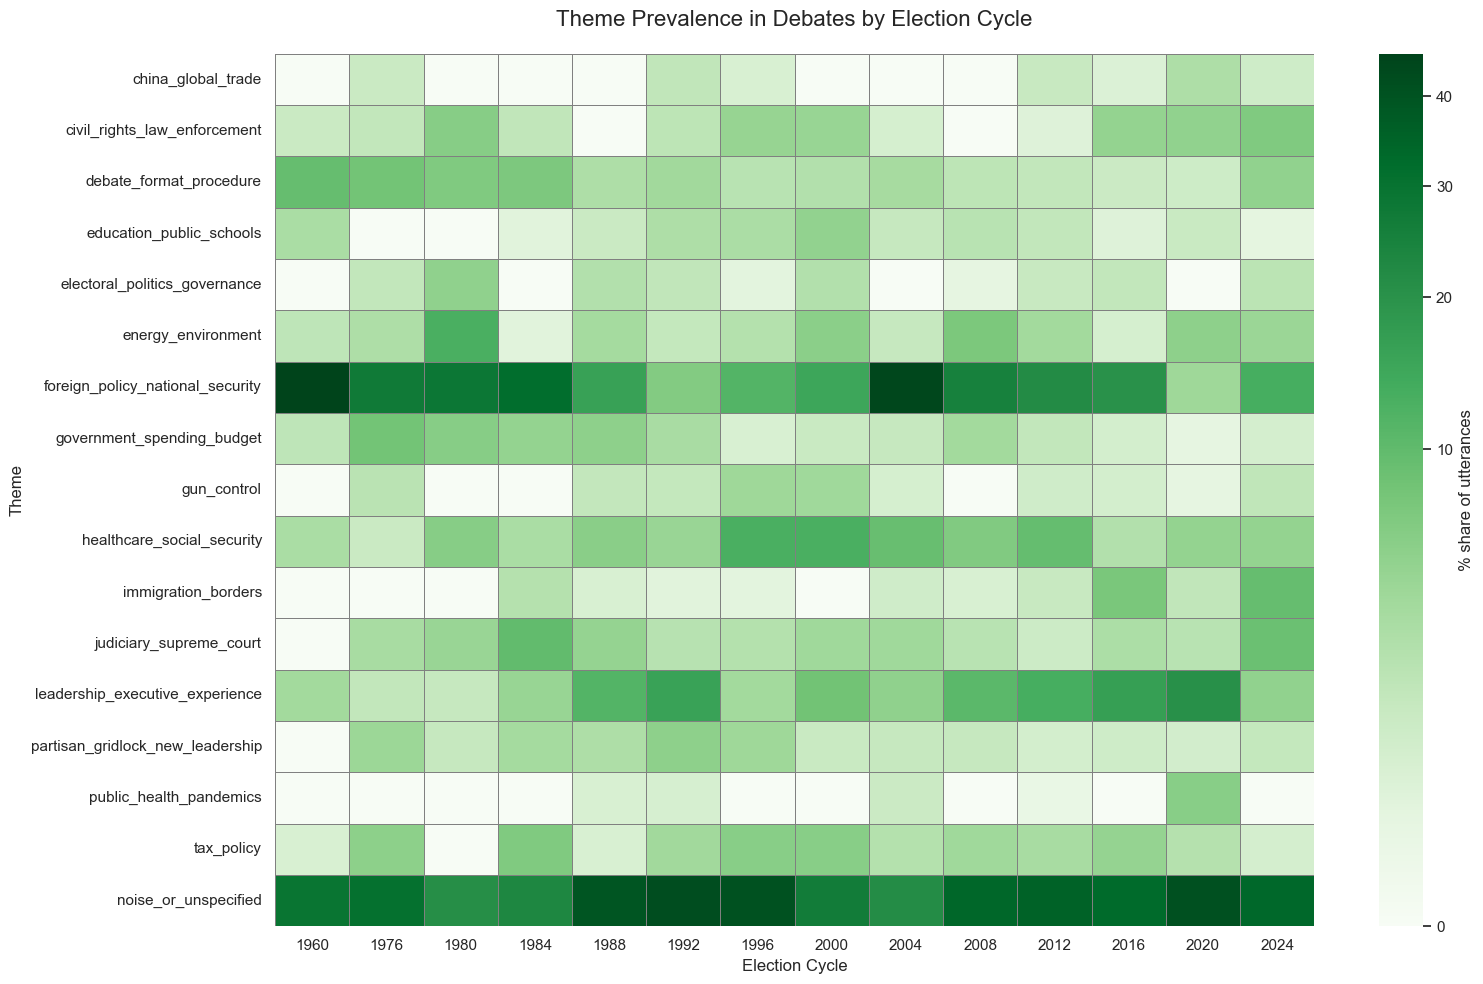

In [105]:
# === THEME PREVALENCE HEATMAP (IMPROVED) ===

from matplotlib.colors import PowerNorm

# aggregate theme % per election cycle
theme_cycle = (
    debates.groupby(["year", "theme"])
    .size()
    .reset_index(name="count")
)
cycle_totals = theme_cycle.groupby("year")["count"].transform("sum")
theme_cycle["pct"] = theme_cycle["count"] / cycle_totals * 100

# pivot for heatmap
heatmap_data = theme_cycle.pivot(index="theme", columns="year", values="pct").fillna(0)

# move noise_or_unspecified to bottom
if "noise_or_unspecified" in heatmap_data.index:
    noise_row = heatmap_data.loc[["noise_or_unspecified"]]
    heatmap_data = heatmap_data.drop("noise_or_unspecified")
    heatmap_data = pd.concat([heatmap_data, noise_row])

plt.figure(figsize=(16, 10))
sns.heatmap(
    heatmap_data,
    cmap="Greens",
    linewidths=0.5, linecolor="gray",
    norm=PowerNorm(gamma=0.4),  # boost lower values for better contrast
    cbar_kws={"label": "% share of utterances"},
)

plt.title("Theme Prevalence in Debates by Election Cycle", fontsize=16, pad=20)
plt.xlabel("Election Cycle")
plt.ylabel("Theme")
plt.tight_layout()
plt.show()

The heatmap above traces the **prevalence of debate themes across election cycles from 1960 to 2024**. Each row corresponds to a theme, and the shading represents the share of utterances devoted to that theme in a given cycle.  

A few clear patterns emerge:  

- **Foreign policy and national security** dominated early debates, particularly during the Cold War era of the 1960s and 1980s, when U.S.–Soviet tensions framed much of the political discourse. While still present, this theme gradually declined in relative weight after the end of the Cold War.  
- **Healthcare and social security** rose significantly beginning in the 1990s, reflecting demographic changes, the Clinton administration’s reform attempts, and later the Affordable Care Act.  
- **Immigration and borders**, barely present before the 2000s, became a recurring theme in recent decades, particularly in 2016 and 2020, when immigration was a centerpiece of partisan conflict.  
- **Public health and pandemics**, absent from debate discourse for decades, only appears in 2020, during the COVID-19 crisis, highlighting how external shocks inject new themes into the political agenda.  
- **Civil rights and law enforcement** appear periodically, often tied to moments of heightened social conflict (1960s civil rights movement, 1990s policing debates, 2020 Black Lives Matter protests).  
- **Tax policy and government spending** persist as stable anchors of debate discourse, even as their relative prominence fluctuates.  
- Finally, the share of **“noise or unspecified”** themes — utterances too generic or fragmented to cluster clearly — remains high throughout. This suggests that not all debate content fits neatly into thematic categories, but it also raises questions about the increasing use of generalities and unspecific rhetoric.  

Taken together, this visualization demonstrates that the agenda of U.S. presidential debates is not static. It evolves in response to **historical events (Cold War, 9/11, the Great Recession, COVID-19)** and **partisan priorities**, reflecting the changing concerns that candidates believe will resonate with the electorate.  

#### How do Policy-Related Themes Vary?

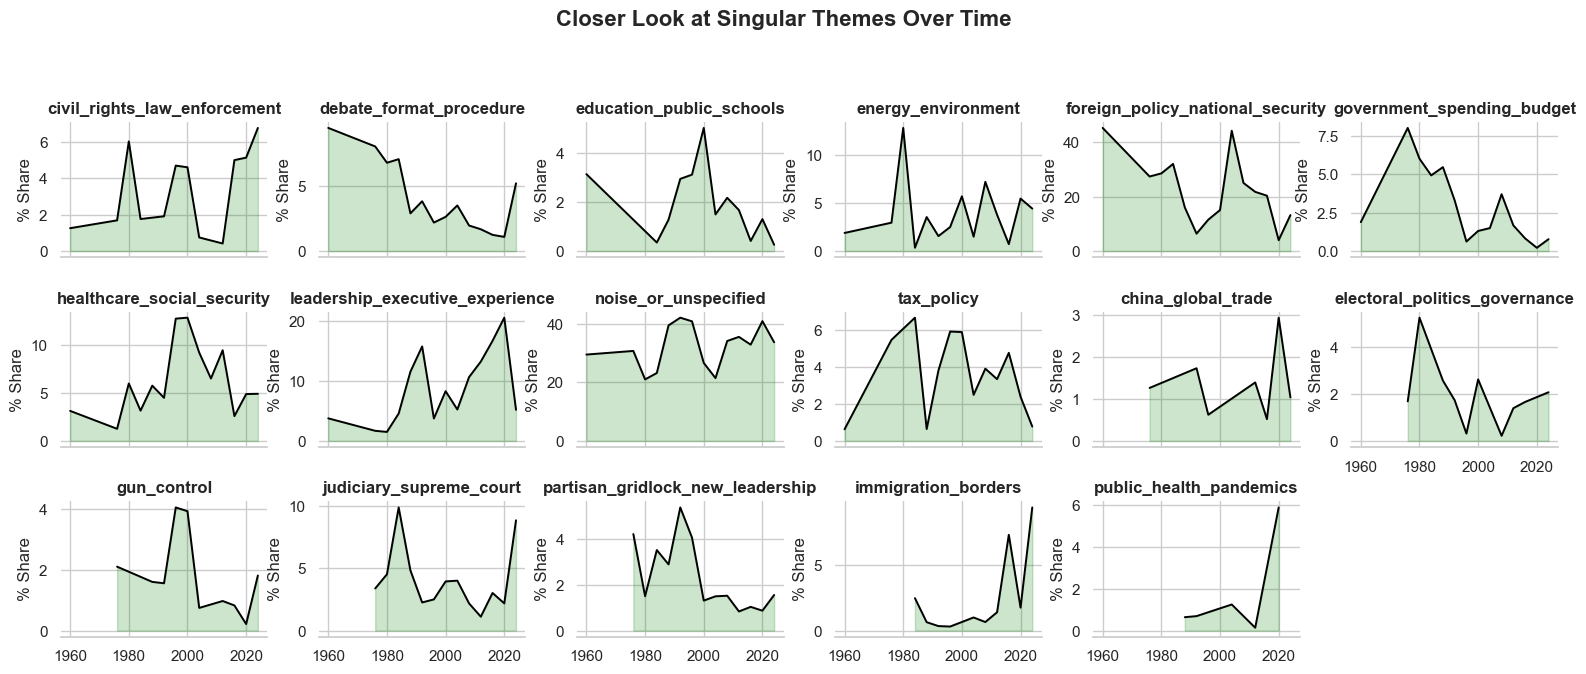

In [34]:
# === SMALL MULTIPLES GRID FOR THEMES ===

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# grid: 6 columns, themes wrap into rows
g = sns.FacetGrid(
    theme_cycle, 
    col="theme", 
    col_wrap=6,     # 6 per row
    aspect=1.2, height=2.2,  # square-ish plots
    sharey=False
)

# line + fill
g.map_dataframe(
    sns.lineplot, 
    x="year", y="pct", 
    color="black", linewidth=1.4
)
g.map_dataframe(
    plt.fill_between, 
    "year", "pct", 
    alpha=0.2, color="green"
)

# style adjustments
g.set_titles("{col_name}", fontsize=10, fontweight="bold")
g.set(xlabel="", ylabel="% Share")
g.set(xticks=[1960, 1980, 2000, 2020]) 
g.despine(left=True)

# add global title
g.fig.suptitle(
    "Closer Look at Singular Themes Over Time",
    fontsize=16, fontweight="bold",
    y=1.05
)

plt.subplots_adjust(top=0.88, hspace=0.4, wspace=0.25)  # center & spacing
plt.show()

Breaking the debates down by singular themes reveals the **distinct trajectories of political issues** over time. Each panel shows how a theme’s share of debate utterances has risen or declined from 1960 to 2024.

- **Foreign policy and national security** starts as the dominant concern of early debates but steadily declines, reflecting the end of the Cold War and the shift toward domestic priorities. Peaks around 1980 and 2004 correspond to the Soviet crisis and post-9/11 wars.  
- **Healthcare and social security** steadily gains ground from the 1980s onward, mirroring the rising salience of Medicare, the Affordable Care Act, and aging demographics.  
- **Immigration and borders** is a late entrant, barely present before the 2000s but surging in 2016 and 2020 — highlighting how partisan conflict elevated it into a central debate topic.  
- **Energy and environment** show periodic spikes, often tied to crises (1970s oil shocks, 2000s climate change debates).  
- **Civil rights and law enforcement** recur across decades, from the civil rights movement of the 1960s to Black Lives Matter in 2020.  
- **Gun control** appears episodically, peaking in cycles following high-profile mass shootings.  
- **Leadership and executive experience** rises in moments of electoral volatility, often when outsider candidates challenge traditional figures.  
- **Public health and pandemics** only enters in 2020, showing how debates absorb extraordinary crises into their language.  
- **Noise or unspecified utterances** remain consistently high, suggesting that much of debate rhetoric remains broad, vague, or discursive rather than tied to clear issues.  

This closer lens reinforces the point: **debate agendas are not static**. They expand, contract, and refocus depending on historical shocks and partisan strategy. Some themes — like tax policy and government spending — persist across decades, while others, like pandemics or immigration, explode suddenly into the spotlight.  

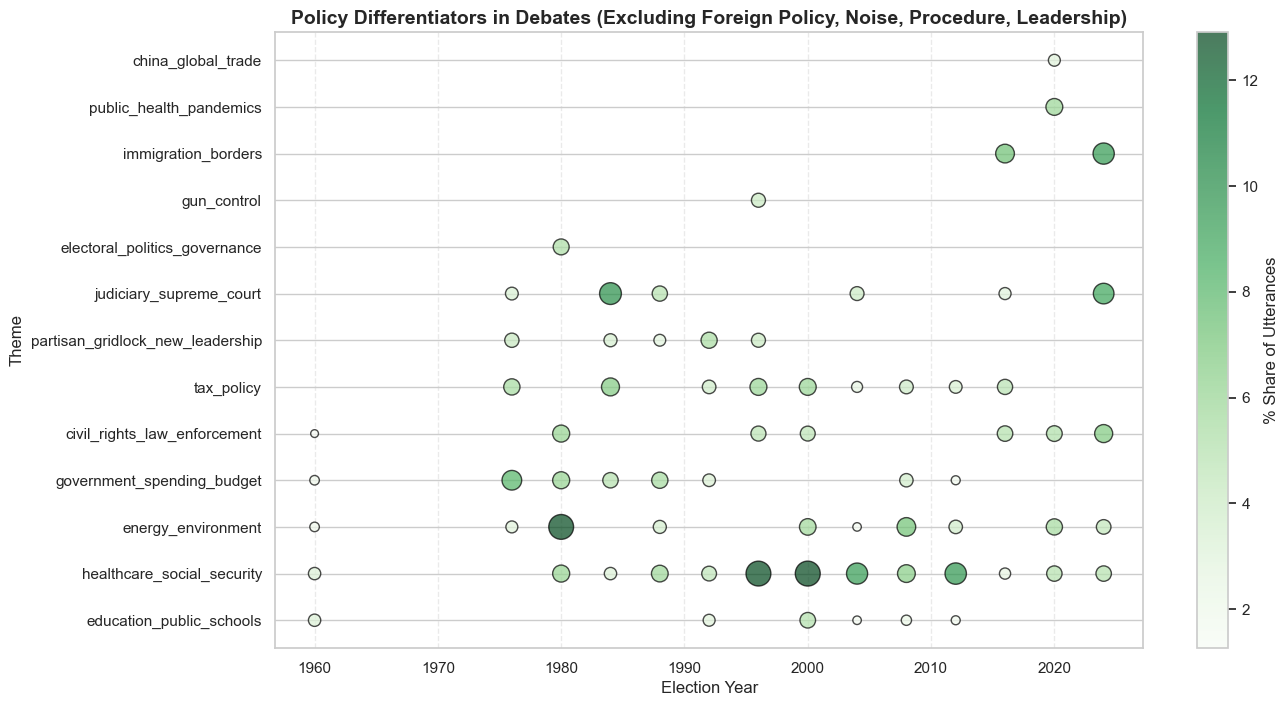

In [35]:
# === FILTERED POLICY-FOCUSED BUBBLE TIMELINE ===

# themes to exclude
exclude_themes = [
    "foreign_policy_national_security", 
    "noise_or_unspecified",
    "debate_format_procedure",
    "leadership_executive_experience"
]

focus = theme_cycle[~theme_cycle["theme"].isin(exclude_themes)]

# top 5 per election year among remaining themes
topk_focus = focus.groupby("year").apply(
    lambda d: d.nlargest(5, "pct")
).reset_index(drop=True)

plt.figure(figsize=(14, 8))

# bubble plot with green shades (darker = higher %)
scatter = plt.scatter(
    topk_focus["year"], topk_focus["theme"],
    s=topk_focus["pct"] * 25,
    c=topk_focus["pct"], cmap="Greens",  # colormap shades of green
    alpha=0.7, edgecolor="black"
)

plt.colorbar(scatter, label="% Share of Utterances")

plt.title("Policy Differentiators in Debates (Excluding Foreign Policy, Noise, Procedure, Leadership)",
          fontsize=14, fontweight="bold")
plt.xlabel("Election Year")
plt.ylabel("Theme")
plt.grid(axis="x", linestyle="--", alpha=0.4)

plt.show()

This bubble chart focuses on **domestic and policy-oriented themes**, excluding overarching categories like foreign policy, debate procedure, and leadership. The size and color of each bubble reflect the share of utterances a theme receives in a given election year.

The visualization highlights how **certain themes act as differentiators** across cycles:

- **Healthcare and social security** consistently rank among the most significant themes from the 1980s onward, with especially strong peaks in the 1990s and early 2000s during healthcare reform debates.  
- **Immigration and borders**, nearly absent until the 2000s, become central from 2016 onwards, signaling the transformation of immigration into a defining partisan wedge issue.  
- **Public health and pandemics** emerge suddenly in 2020 as COVID-19 dominated the political agenda — a reminder of how crises can restructure debate priorities overnight.  
- **Energy and environment** spike in cycles tied to oil shocks and later to climate change discourse.  
- **Civil rights and law enforcement** recur periodically, surfacing most strongly in the 1960s and again in 2020, reflecting both the civil rights movement and Black Lives Matter protests.  
- **Judiciary and the Supreme Court** has grown in salience, peaking in 1984 and 2024, paralleling growing polarization over judicial appointments and decisions on abortion rights.  
- **Tax policy** and **government spending** remain constant anchors, shaping nearly every cycle, though their relative weight has fluctuated.  

What emerges is a picture of **continuities and ruptures**: some themes (taxes, spending, healthcare) act as *structural constants* of presidential debates, while others (immigration, pandemics) burst into prominence only when external shocks or partisan strategies elevate them.  

This dynamic demonstrates how debates serve both as **mirrors of historical context** and as **arenas for reframing political conflict** in line with the priorities of the moment.  

#### Subtheme Evolution 

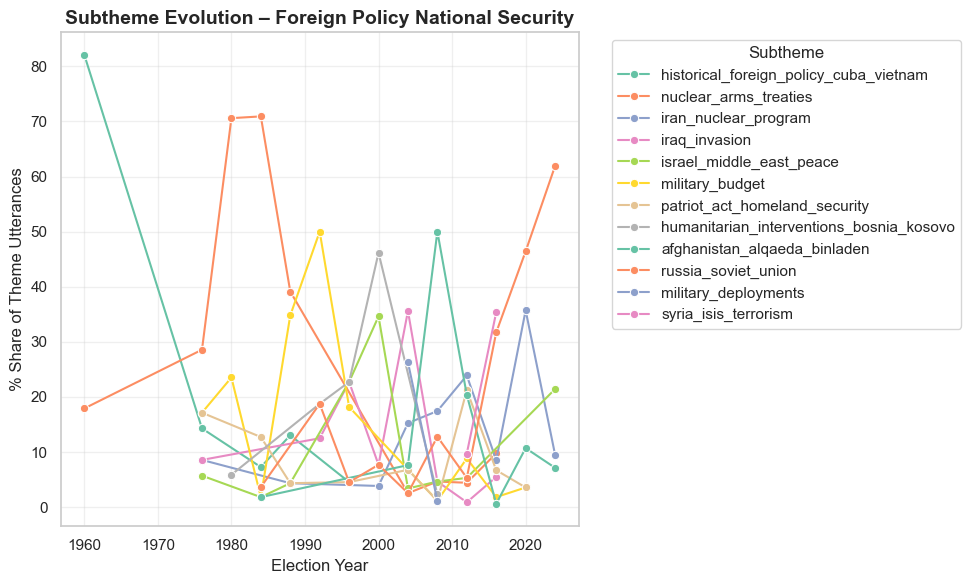

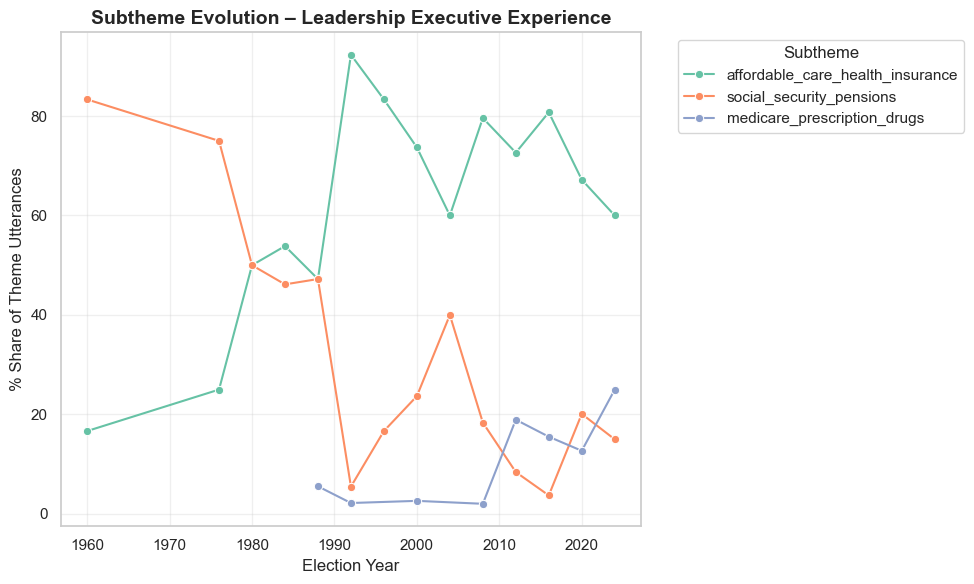

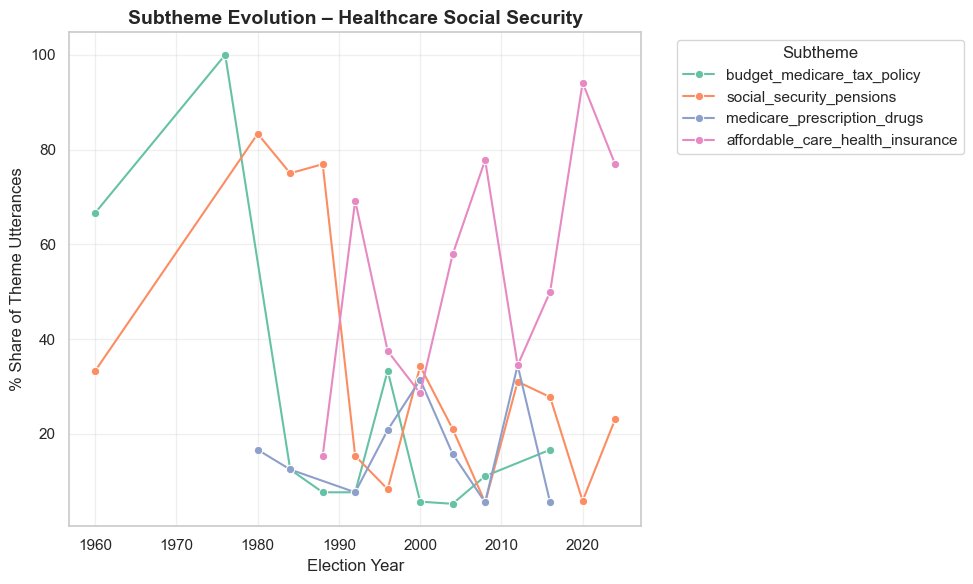

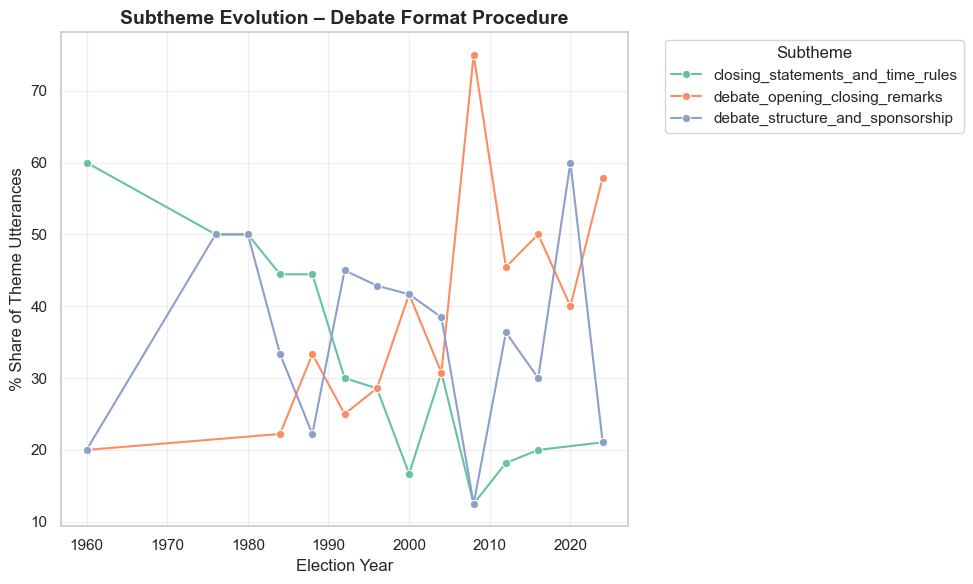

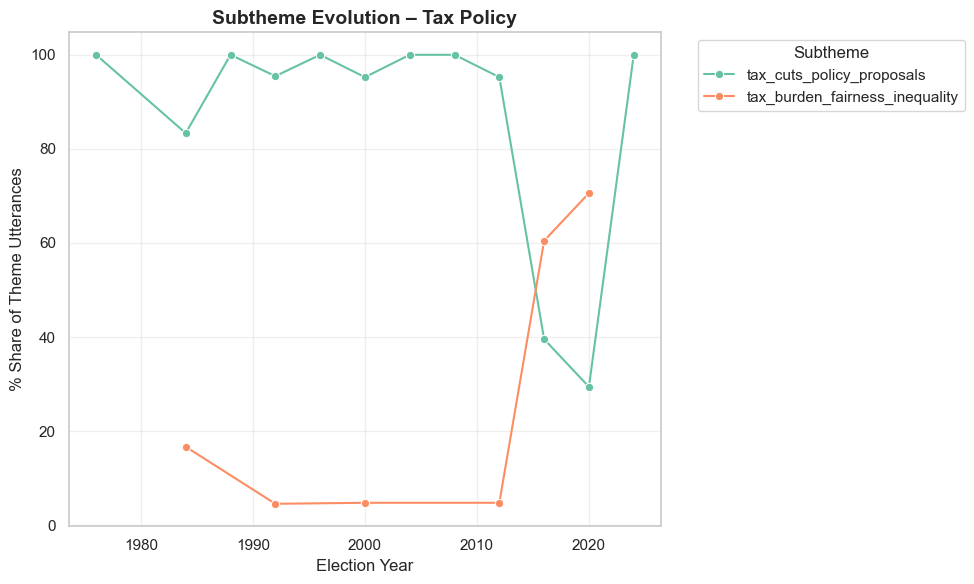

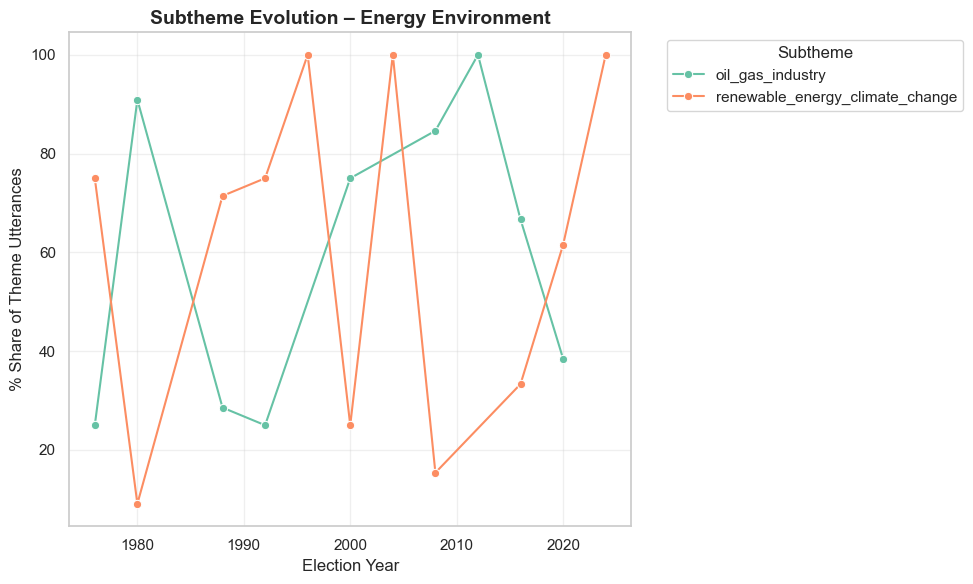

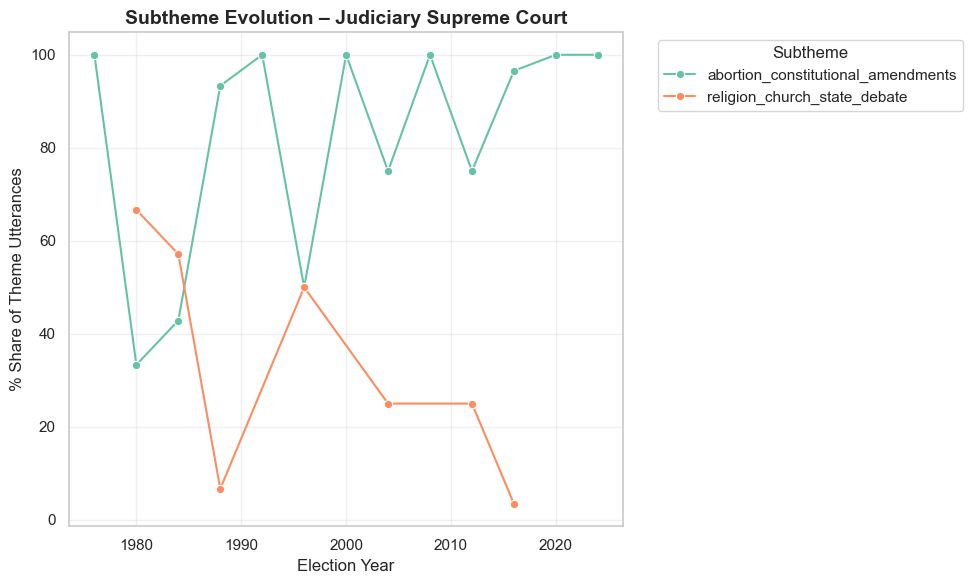

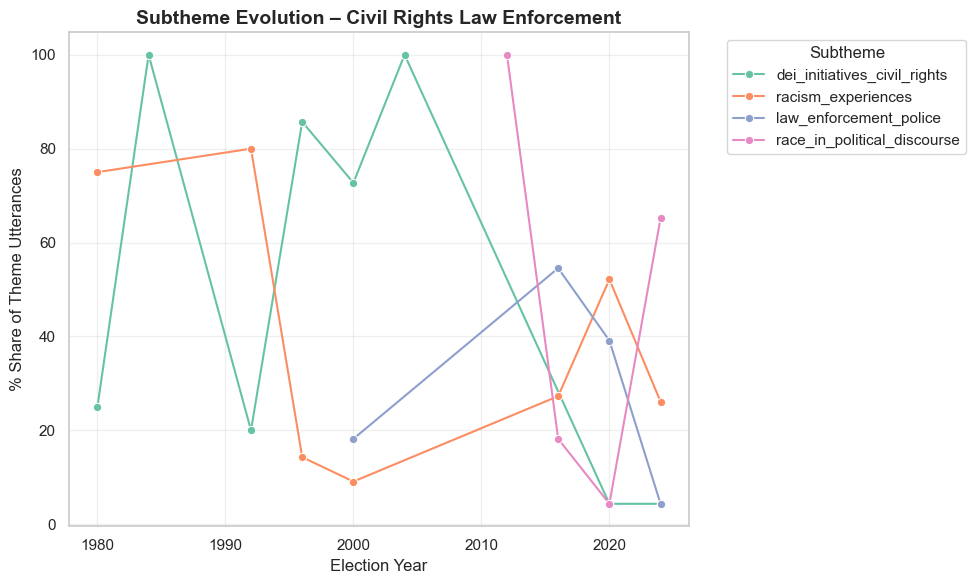

In [36]:
# === INDIVIDUAL SUBTHEME PLOTS PER THEME (CREST PALETTE) ===

import matplotlib.pyplot as plt
import seaborn as sns

# collect all themes that actually have subthemes
themes_with_subs = debates[debates["subtheme"].notna()]["theme"].unique().tolist()

for theme in themes_with_subs:
    df_theme = (
        debates[debates["theme"] == theme]
        .groupby(["year", "subtheme"])
        .size()
        .reset_index(name="count")
    )
    if df_theme.empty:
        continue

    # normalize within theme
    df_theme["total"] = df_theme.groupby("year")["count"].transform("sum")
    df_theme["pct"] = df_theme["count"] / df_theme["total"] * 100

    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=df_theme,
        x="year", y="pct", hue="subtheme", marker="o",
        palette="Set2"
    )

    plt.title(f"Subtheme Evolution – {theme.replace('_', ' ').title()}", fontsize=14, fontweight="bold")
    plt.xlabel("Election Year")
    plt.ylabel("% Share of Theme Utterances")
    plt.legend(title="Subtheme", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

Looking beyond broad themes, these plots reveal how **specific subtopics rise and fall within larger policy areas**. This granularity shows how the language of debates adapts to historical shocks, partisan strategy, and shifting voter concerns.

- **Foreign policy and national security**  
  Early debates were dominated by the Cold War, with *Russia/Soviet Union* and *historical conflicts (Cuba, Vietnam)* taking center stage. Over time, new subthemes emerged: *nuclear arms treaties* in the 1980s, *Afghanistan and Iraq* after 2001, and *Syria/ISIS* in the 2010s. The reappearance of *Russia* in 2020–2024 highlights the return of great-power rivalry.  

- **Healthcare and social security**  
  In the 1960s–80s, debates centered on *social security and pensions*. From the 1990s onward, the discourse pivoted to *affordable care and health insurance*, reflecting the Clinton reforms, the Affordable Care Act, and subsequent Republican efforts to dismantle it. *Medicare prescription drugs* emerged as a niche but recurring subtheme in the 2000s.  

- **Tax policy**  
  For decades, tax debates were framed mainly around *tax cuts and proposals*. Since 2016, however, candidates increasingly emphasized *fairness and inequality*, marking a shift from technical policy to moral framing of the tax burden.  

- **Energy and environment**  
  The balance swings between *oil and gas industry* concerns (1970s–2000s) and *renewable energy/climate change* (2000s–2020s). The rising prominence of climate change as a subtheme underscores the gradual politicization of environmental issues.  

- **Judiciary and the Supreme Court**  
  In the 1980s–1990s, both *abortion amendments* and *religion/church-state debates* were present. By the 2000s, abortion overwhelmingly dominated the subtheme distribution — reflecting the centrality of reproductive rights in judicial politics.  

- **Civil rights and law enforcement**  
  Subthemes evolve alongside social movements: *racism and civil rights* in the 1980s, *policing and law enforcement* around the 2000s, and *race in political discourse* linked to Black Lives Matter in 2016–2020.  

- **Debate format and procedure**  
  Even procedural talk shifts — from *closing statements and time rules* in early debates to *structure and sponsorship* in later ones, with *opening/closing remarks* reemerging as candidates contest moderator fairness.  

Together, these subtheme trajectories reveal how **debate language both mirrors the historical moment (wars, pandemics, civil rights movements)** and **reconfigures recurring issues under new frames**. Cold War anxieties, healthcare reforms, climate change, and abortion debates are not new concerns — but the **subtopics and vocabulary used to debate them evolve**, offering a window into the political imagination of each era.  

In [37]:
# === ALLUVIAL FLOW: THEMES → SUBTHEMES ===

import plotly.graph_objects as go

# aggregate data
df_alluvial = (
    debates.groupby(["theme", "subtheme"])
    .size()
    .reset_index(name="count")
)

# filter out NaN subthemes
df_alluvial = df_alluvial[df_alluvial["subtheme"].notna()]

# build node list: themes + subthemes
themes = df_alluvial["theme"].unique().tolist()
subthemes = df_alluvial["subtheme"].unique().tolist()
nodes = themes + subthemes

# mapping theme/subtheme to indices
node_index = {n: i for i, n in enumerate(nodes)}

# links: theme → subtheme
links = []
for _, row in df_alluvial.iterrows():
    links.append(dict(
        source=node_index[row["theme"]],
        target=node_index[row["subtheme"]],
        value=row["count"]
    ))

# Sankey figure
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=40,
        thickness=25,
        line=dict(color="black", width=0.5),
        label=nodes,
        color="lightgreen"
    ),
    link=dict(
        source=[l["source"] for l in links],
        target=[l["target"] for l in links],
        value=[l["value"] for l in links],
        color="rgba(34,139,34,0.4)"   # semi-transparent green
    )
)])

fig.update_layout(
    title_text="Alluvial Flow of Debate Themes and Subthemes",
    font_size=12
)

fig.show()

The alluvial diagram above illustrates how **broad debate themes branch into specific subthemes**, capturing the internal diversity of issues discussed on the debate stage. Each band represents the share of utterances flowing from a general category (left) into its more granular components (right).

A few patterns stand out:

- **Foreign policy and national security** splinters into a wide array of subtopics — from *nuclear arms treaties* and *Russia/Soviet Union* in the Cold War era, to *Afghanistan, Iraq, and ISIS* in the 2000s, and back to *Russia* in the 2020s. This breadth reflects the way international crises repeatedly redefined U.S. foreign policy discourse.  
- **Healthcare and social security** is pulled strongly toward *affordable care and health insurance* in recent decades, reflecting how the Affordable Care Act and its aftermath became the defining health policy battle. Earlier subthemes such as *social security pensions* or *budget/Medicare overlaps* remain present but diminished.  
- **Judiciary and the Supreme Court** is dominated by *abortion and constitutional amendments*, underscoring how one issue came to eclipse other legal or religious debates.  
- **Tax policy** divides between *policy proposals* and a growing emphasis on *fairness and inequality*, showing a reframing of taxation from a technical matter into a moral-political battleground.  
- **Civil rights and law enforcement** distributes across subthemes of *racism*, *policing*, and *race in political discourse*, aligning closely with moments of social upheaval.  
- **Energy and environment** increasingly balances between *oil and gas* concerns and *renewable energy/climate change*, reflecting the gradual politicization of environmental policy.  

This flow makes visible what aggregate counts obscure: debates are not only about which **themes** are present, but about which **aspects of those themes** dominate at different moments in history. The expansion of foreign policy into terrorism and Middle East subthemes after 2001, or the consolidation of judicial debates almost entirely around abortion, demonstrate how **debate agendas are continually reshaped by historical shocks and partisan priorities**.  

### 1.2. Partisan Differences in Themes

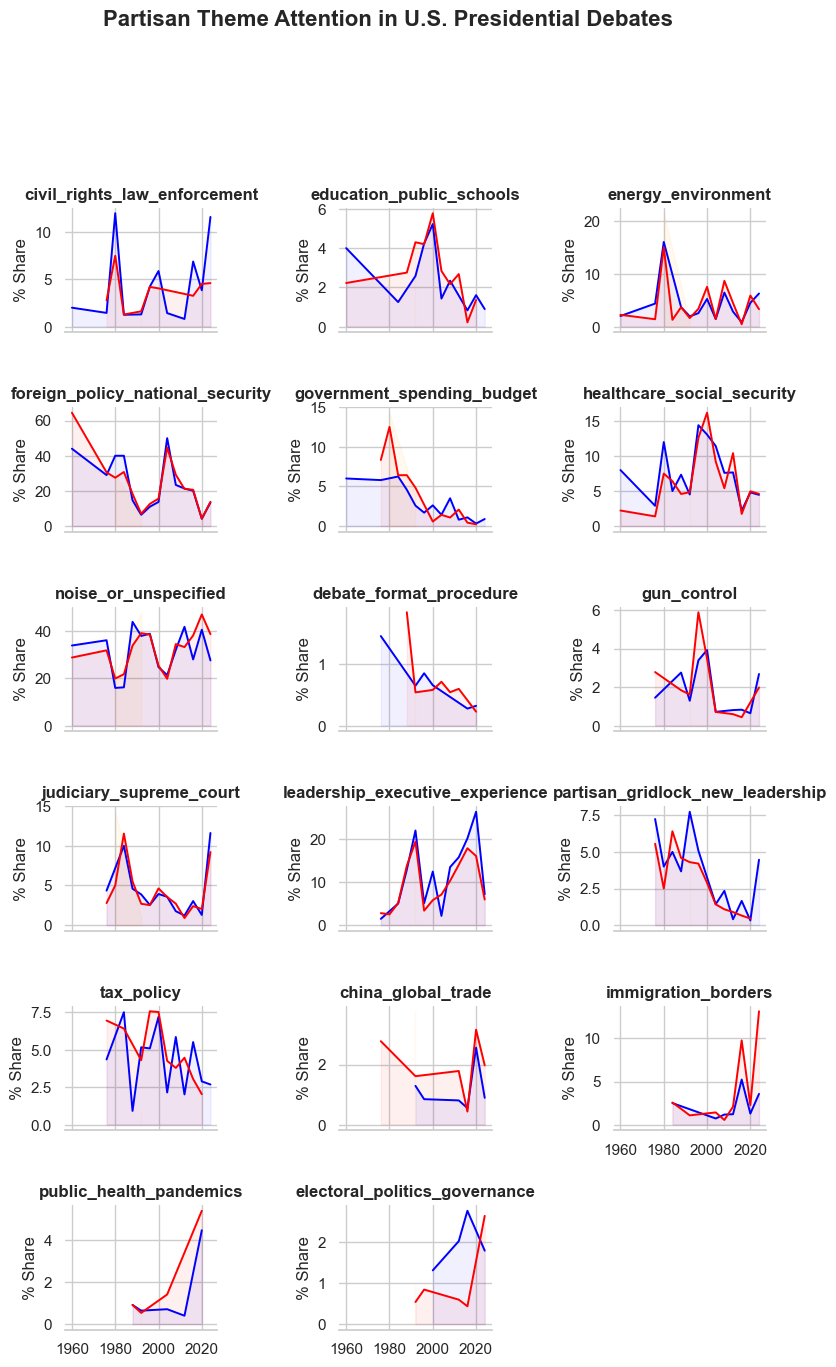

In [55]:
# === SMALL MULTIPLES GRID FOR THEMES (PARTISAN) ===

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# aggregate theme % per year × party
party_theme = (
    debates.groupby(["year", "party_code", "theme"])
    .size()
    .reset_index(name="count")
)
party_totals = party_theme.groupby(["year", "party_code"])["count"].transform("sum")
party_theme["pct"] = party_theme["count"] / party_totals * 100

# Facet grid: one subplot per theme
g = sns.FacetGrid(
    party_theme, 
    col="theme", 
    col_wrap=3, 
    aspect=1.2, height=2.2, 
    sharey=False
)

# Democrat line + fill
g.map_dataframe(
    sns.lineplot, 
    x="year", y="pct", hue="party_code",
    hue_order=["D", "R"],  # ensure consistent ordering
    palette={"D": "blue", "R": "red"},
    linewidth=1.4
)

# fill areas under curves
def partisan_fill(data, color_map={"D":"blue","R":"red","I":"orange"}, alpha=0.06, **kwargs):
    ax = plt.gca()
    for party, group in data.groupby("party_code"):
        if party in color_map:
            ax.fill_between(group["year"], group["pct"], alpha=alpha, color=color_map[party])

party_theme = party_theme[party_theme["party_code"].isin(["D","R"])]

g.map_dataframe(partisan_fill)

# style
g.set_titles("{col_name}", fontsize=5, fontweight="bold")
g.set(xlabel="", ylabel="% Share")
g.set(xticks=[1960, 1980, 2000, 2020])
g.despine(left=True)

# global title
g.fig.suptitle(
    "Partisan Theme Attention in U.S. Presidential Debates",
    fontsize=16, fontweight="bold",
    y=1.05
)

plt.subplots_adjust(top=0.9, hspace=0.6, wspace=0.8)
plt.show()

This figure tracks **theme attention by party** across presidential debates from 1960 to 2024. Red lines represent Republicans, blue lines represent Democrats, and the y-axis shows the share of utterances devoted to each theme.

Several partisan contrasts emerge:

- **Foreign policy and national security**  
  Dominant for both parties in early debates, but Republicans traditionally gave it slightly greater weight. The gap narrows after the Cold War, with both parties converging around shared peaks post-9/11.  

- **Healthcare and social security**  
  Democrats consistently emphasize healthcare more strongly, especially during cycles tied to reform efforts (1990s, 2008–2012). Republicans mention it less, often in the context of cost and deficit concerns.  

- **Immigration and borders**  
  The starkest partisan wedge: Republicans devote substantially more attention from 2016 onward, while Democrats mention it only marginally. This confirms immigration as a defining Republican issue of the 21st century.  

- **Energy and environment**  
  Both parties spike attention in moments of crisis (oil shocks, climate debates), but Republicans typically stress energy independence while Democrats stress climate change.  

- **Civil rights and law enforcement**  
  Democrats’ attention increases during cycles tied to racial justice movements (1960s, 2020), while Republicans address it more sporadically, often tied to law-and-order appeals.  

- **Judiciary and the Supreme Court**  
  Attention spikes for both parties in cycles tied to abortion and judicial appointments (1980s, 2020s). The judiciary has become a bipartisan flashpoint, though the substantive framing differs.  

- **Tax policy and government spending**  
  A long-standing Republican priority, with higher relative attention through most decades. Democrats engage more selectively, often during fiscal crisis debates.  

- **Public health and pandemics**  
  Virtually absent until 2020, when both parties devoted significant attention — though Republicans focused more on pandemic management in the debates that year.  

In sum, **some issues remain bipartisan constants** (foreign policy, judiciary, taxation), while others reveal **growing partisan asymmetry** (healthcare, immigration, civil rights). The overall trend is one of **polarized issue ownership**, where each party selectively amplifies the themes it can use to mobilize its base and draw sharp contrasts with the opponent.  

### 1.3. Media Alignment

#### Does Media Represent the Same Issues as Debates?

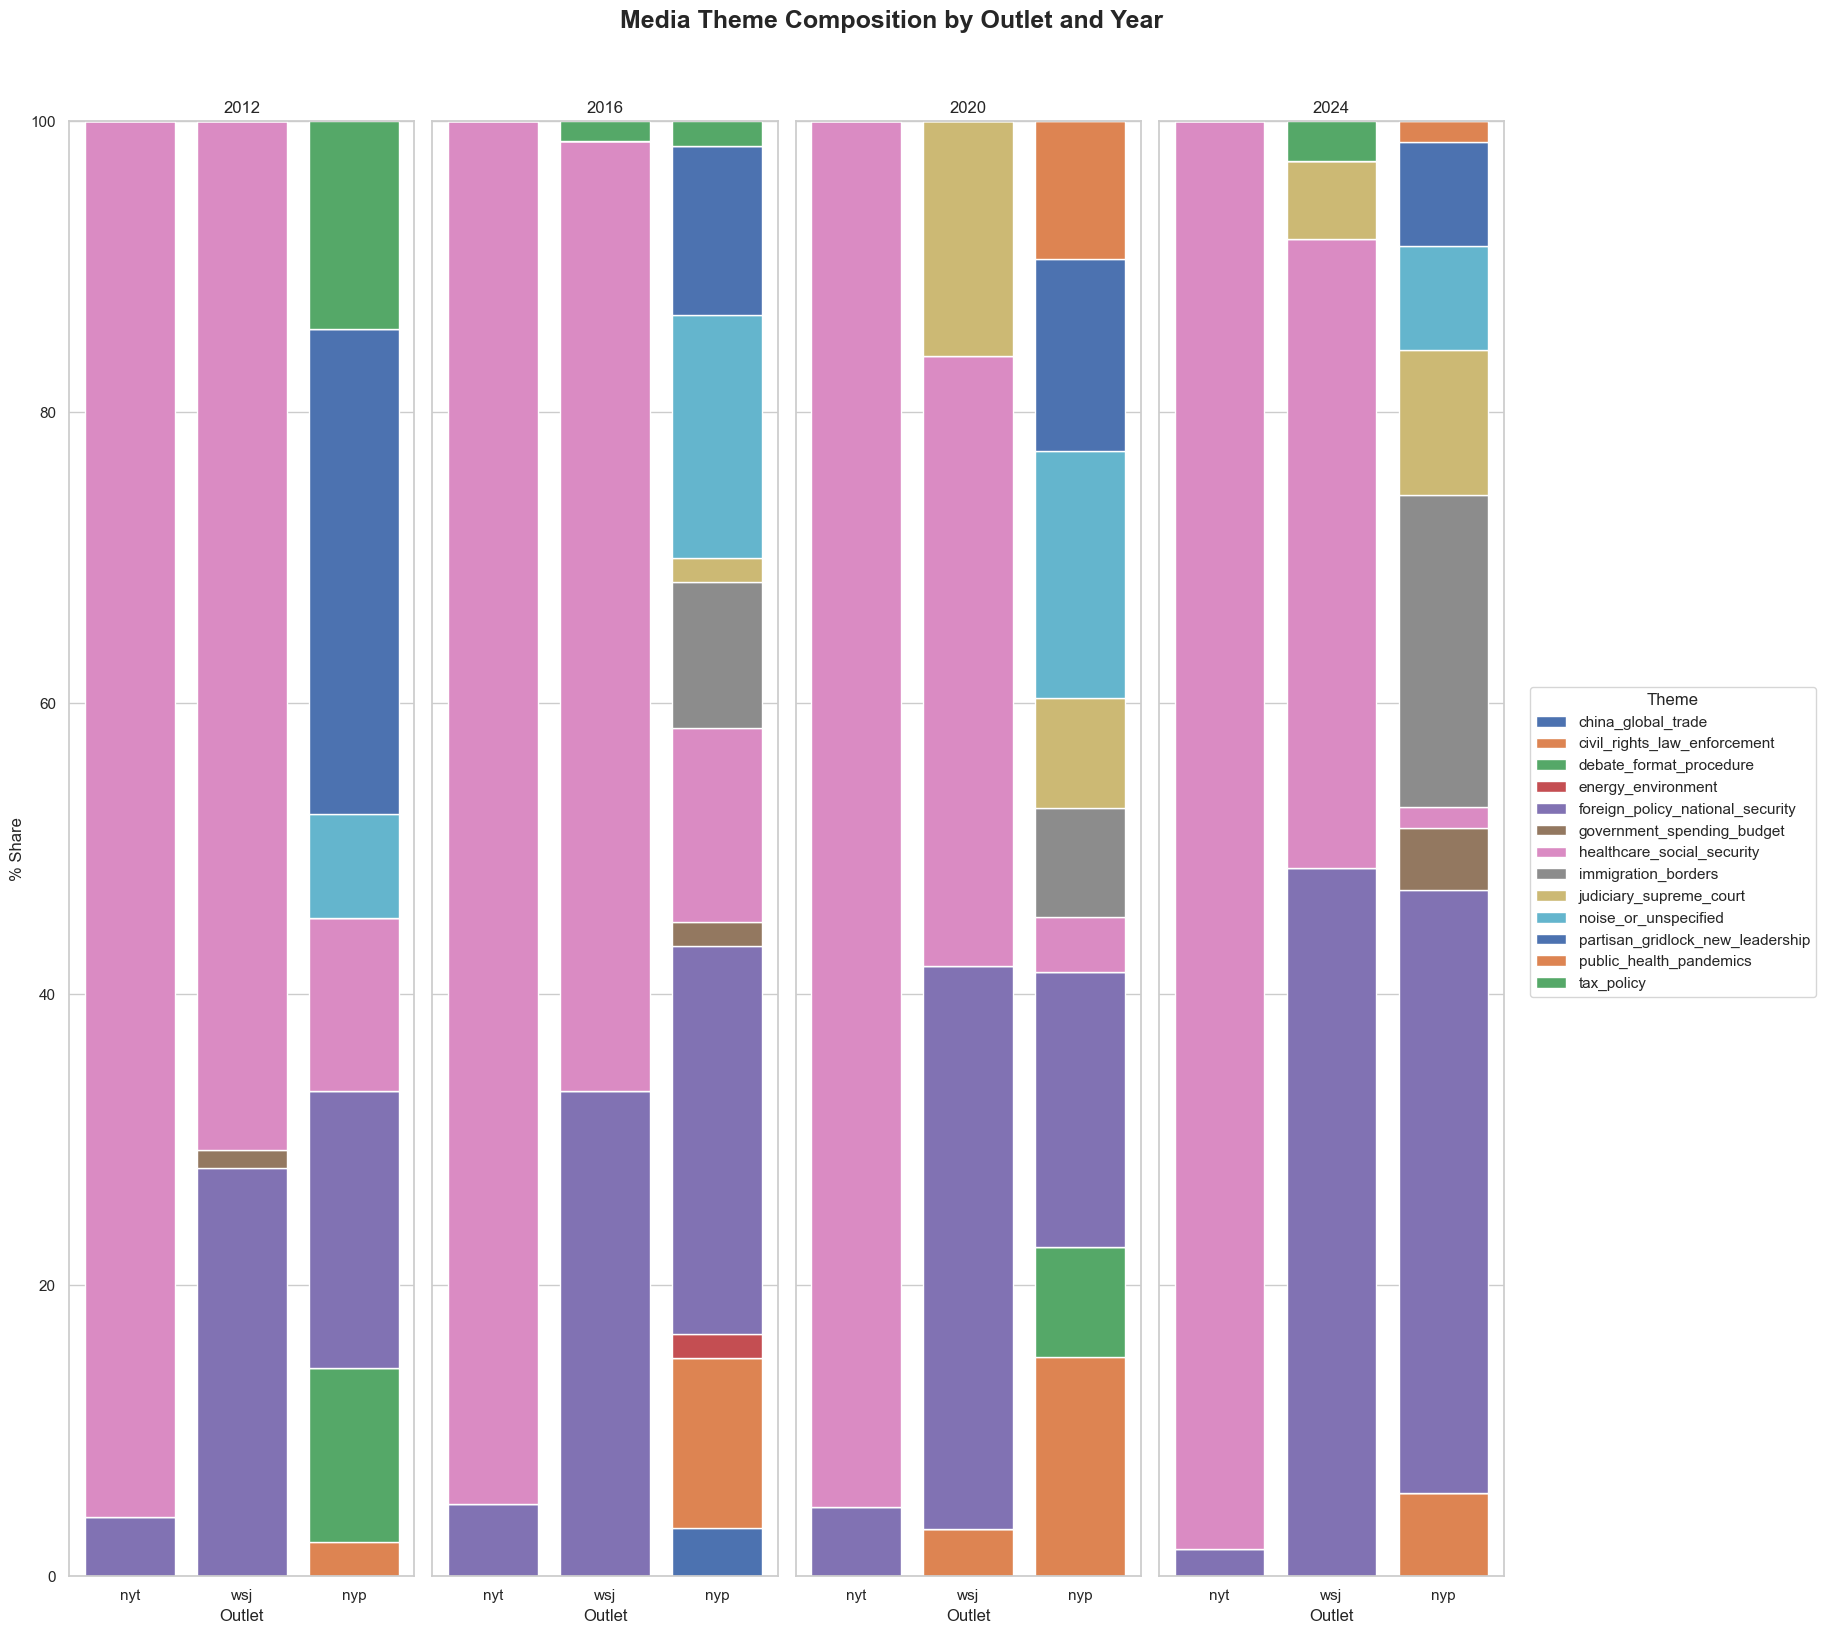

In [79]:
# === STACKED BAR CHARTS: MEDIA THEME COMPOSITION ACROSS OUTLETS AND ELECTION CYCLES ===

# prepare stacked bar data 
media_cycle = (
    media.groupby(["year", "outlet", "theme"])
    .size()
    .reset_index(name="count")
)
outlet_totals = media_cycle.groupby(["year", "outlet"])["count"].transform("sum")
media_cycle["pct"] = media_cycle["count"] / outlet_totals * 100

# pivot for stacked bars
bar_data = media_cycle.pivot_table(
    index=["year","outlet"], columns="theme", values="pct", fill_value=0
)

# plot stacked bars
outlets_order = ["nyt","wsj","nyp"]  # control outlet order
years = sorted(media_cycle["year"].unique())

fig, axes = plt.subplots(1, len(years), figsize=(18, 16), sharey=True)

for i, year in enumerate(years):
    ax = axes[i]
    subset = bar_data.loc[year]
    subset = subset.reindex(outlets_order)  # ensure consistent order
    
    # plot stacked bars
    bottom = np.zeros(len(subset))
    for theme in subset.columns:
        ax.bar(
            subset.index, subset[theme], bottom=bottom, label=theme
        )
        bottom += subset[theme].values
    
    ax.set_title(str(year))
    ax.set_xlabel("Outlet")
    if i == 0:
        ax.set_ylabel("% Share")
    ax.set_ylim(0, 100)

# single legend outside
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title="Theme", bbox_to_anchor=(0.85, 0.5), loc="center left")

plt.suptitle("Media Theme Composition by Outlet and Year", fontsize=18, fontweight="bold", y=1.02)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

#### Are Media and Debates Convergent in the Issues They Approach?

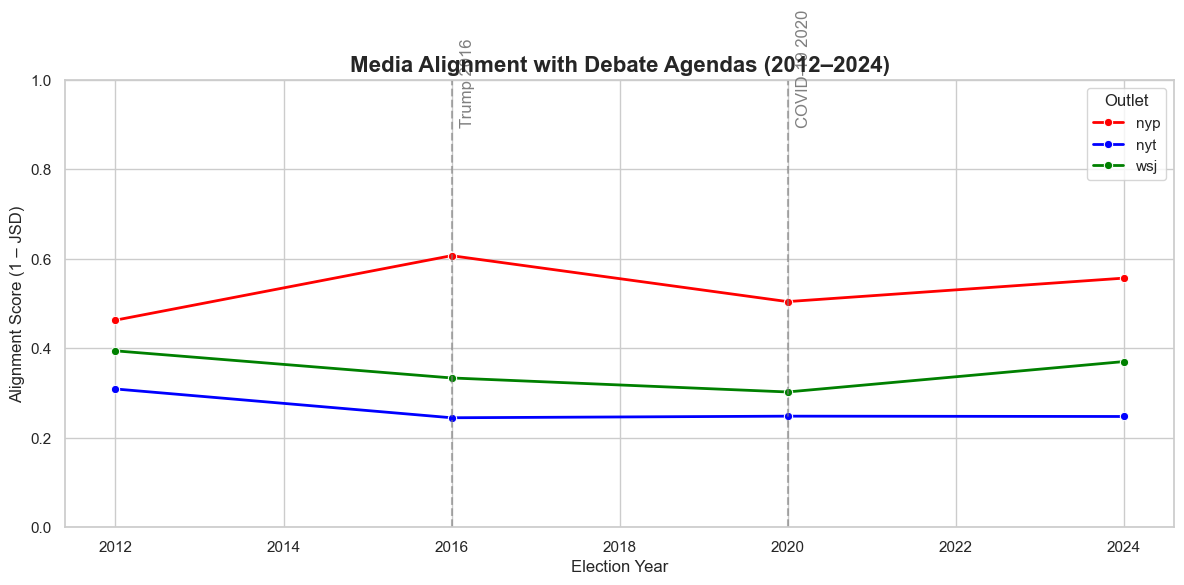

In [81]:
# === DIVERGENCE INDEX (JSD) ===

from scipy.spatial.distance import jensenshannon

def compute_jsd(p, q):
    """Compute Jensen–Shannon divergence between two distributions."""
    return jensenshannon(p, q)

divergences = []
for year in media_cycle["year"].unique():
    debates_dist = (
        debates[debates["year"] == year]
        .groupby("theme").size()
        .pipe(lambda s: s / s.sum())
    )
    for outlet in media_cycle["outlet"].unique():
        media_dist = (
            media[(media["year"] == year) & (media["outlet"] == outlet)]
            .groupby("theme").size()
            .pipe(lambda s: s / s.sum())
        )
        aligned = debates_dist.align(media_dist, fill_value=0)
        jsd = compute_jsd(aligned[0], aligned[1])
        divergences.append({"year": year, "outlet": outlet, "jsd": jsd})

div_df = pd.DataFrame(divergences)   # 👈 this is div_df

# === Convert JSD to alignment score ===
div_df["alignment"] = 1 - div_df["jsd"]

# set outlet colors
outlet_colors = {"nyt": "blue", "wsj": "green", "nyp": "red"}

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=div_df,
    x="year", y="alignment", hue="outlet",
    palette=outlet_colors, marker="o", linewidth=2
)

# add event annotations
plt.axvline(2016, color="gray", linestyle="--", alpha=0.6)
plt.text(2016.1, 0.9, "Trump 2016", rotation=90, color="gray")

plt.axvline(2020, color="gray", linestyle="--", alpha=0.6)
plt.text(2020.1, 0.9, "COVID-19 2020", rotation=90, color="gray")

# labels & title
plt.title("Media Alignment with Debate Agendas (2012–2024)", fontsize=16, fontweight="bold")
plt.ylabel("Alignment Score (1 – JSD)")
plt.xlabel("Election Year")
plt.ylim(0, 1)  # alignment score between 0–1
plt.legend(title="Outlet")

plt.tight_layout()
plt.show()

In this section, we examined how closely media coverage from three major outlets (NYT, WSJ, NYP) aligned with the agendas set in the presidential debates between 2012 and 2024. The analysis proceeded in two steps:

1. **Theme prevalence in media**  
   - We first visualized the distribution of themes across outlets and election years using heatmaps and stacked barplots.  
   - These helped to highlight *which topics dominated coverage* in each outlet, but also revealed data limitations:  
     - **NYT and WSJ** showed relatively narrow thematic coverage in the dataset (dominated by a few policy areas, particularly healthcare for NYT and foreign policy for WSJ).  
     - **NYP** had broader coverage across themes, making it more directly comparable to debate discourse.  
   - Because of these imbalances, heatmaps and stacked bars were useful descriptively but not the clearest tools for alignment comparisons.

2. **Alignment with debates (Jensen–Shannon divergence)**  
   - To measure agenda similarity more systematically, we computed the **Jensen–Shannon Divergence (JSD)** between debate theme distributions and media theme distributions for each outlet and election year.  
   - We then converted this into an **alignment score** (`1 – JSD`), where higher values indicate greater similarity between debates and media agendas.  
   - The results were plotted as time series with key electoral moments annotated (2016 = Trump, 2020 = COVID).

**Findings:**  
- **NYP** is consistently the **most aligned** with debates, peaking in 2016 when Trump’s election sharpened the overlap between debate and media agendas. Alignment dips slightly in 2020 (COVID introduces new issue dynamics) but remains above other outlets.  
- **NYT** and **WSJ** maintain **lower and flatter alignment scores**, suggesting more **editorial independence** from debate-driven agendas. Their coverage appears to emphasize issues beyond those prioritized in debates.  
- Overall, this shows that *tabloid-style coverage (NYP) tends to mirror the salience of debate topics more closely*, while elite outlets like NYT and WSJ maintain distinct issue priorities.

**Limitations:**  
- Media data are uneven across outlets (with NYT and WSJ underrepresented in some themes), which may affect comparability.  
- The analysis is limited to **theme-level alignment** and does not yet capture framing differences or tone.  
- Thus, while the alignment score provides meaningful insights into agenda overlap, it should be interpreted as one dimension of media–debate relations rather than a full picture of influence.

## 2. Do Politicians and Media Outlets Practice Emotional Coloring?

Step 1. Sentiment over Time (Debates)

Goal: Show whether debates are becoming more negative, neutral, or polarized.

Visualizations:
	1.	Line plots of average sentiment per election cycle
	•	Y = mean sentiment score, X = election year, line = overall average.
	•	Add shaded 95% CI for robustness.
	•	Color lines by party (Ds vs Rs).
	•	Optional: overlay key events (9/11, 2008 crash, 2020 pandemic).
	2.	Stacked area plot of sentiment categories (positive/neutral/negative)
	•	Shows distribution shift per cycle (e.g., neutral rising, positive declining).
	3.	Heatmap of sentiment × theme
	•	X = election cycle, Y = theme, cell = avg sentiment (red = negative, green = positive).
	•	Highlights which issues are framed negatively (immigration, security) vs positively (healthcare).

⸻

Step 2. Emotions over Time (Debates)

Goal: Capture emotional palette — not just positivity/negativity, but what kind of emotion.

Visualizations:
	1.	Stacked bar per cycle (joy, anger, sadness, fear, surprise)
	•	Each bar = one cycle, colors = emotions.
	•	Expect “anger/fear” rising in 2000s–2020s.
	2.	Emotion trend lines by party
	•	Line plot of % anger, % joy, etc.
	•	Party-colored lines → shows Democrats vs Republicans emotional palettes.
	3.	Emotion × theme mosaic
	•	For key themes (immigration, healthcare, foreign policy), show emotion distributions per party.
	•	E.g., Rs talk immigration with anger/fear, Ds with sadness/fairness.

⸻

Step 3. Media Alignment (2012–2024)

Goal: Compare tone of debates with that of outlets.

Visualizations:
	1.	Side-by-side sentiment distributions
	•	Bars: debates vs NYT vs WSJ vs NYP (per cycle).
	•	Expect NYP more negative, NYT more neutral/fairness-oriented.
	2.	Emotion “palette” comparison
	•	Horizontal stacked bars: % emotion categories in debates vs outlets.
	•	Outlet logos as labels for intuitive storytelling.
	3.	Sentiment/Emotion Divergence Metric
	•	JSD or cosine divergence between debate distributions and each outlet’s.
	•	Line plot across cycles to see which outlet tracks debates most closely.

⸻

Step 4. Candidate-Level Spotlights (Optional but engaging)

Goal: Humanize the trends by showing individuals.

Visualizations:
	1.	Candidate sentiment profiles
	•	Boxplots of sentiment score per candidate across all utterances.
	•	Trump heavily negative, Obama more positive/neutral?
	2.	Candidate emotion fingerprints
	•	Radar/polar plot of emotion proportions per candidate.
	•	Great for storytelling (e.g., “Biden = sadness/concern, Trump = anger, Obama = optimism/joy”).

### 2.1. Sentiment Over Time (Debates)

In [89]:
# === HELPERS: SHARE OF A SENTIMENT BY PARTY-YEAR ===

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

party_palette = {"D": "#2C7BB6", "R": "#D7191C", "I": "#FDAE61"}

def sentiment_share(df, sentiment):
    # total utterances per year × party (denominator)
    totals = (
        df.groupby(["year", "party_code"])
          .size()
          .reset_index(name="total")
    )
    # numerator: utterances with the chosen sentiment per year × party
    numer = (
        df[df["sentiment"] == sentiment]
        .groupby(["year", "party_code"])
        .size()
        .reset_index(name="count")
    )
    # merge and compute %
    out = totals.merge(numer, on=["year", "party_code"], how="left")
    out["count"] = out["count"].fillna(0)
    out["pct"] = out["count"] / out["total"] * 100
    return out.sort_values(["party_code", "year"])

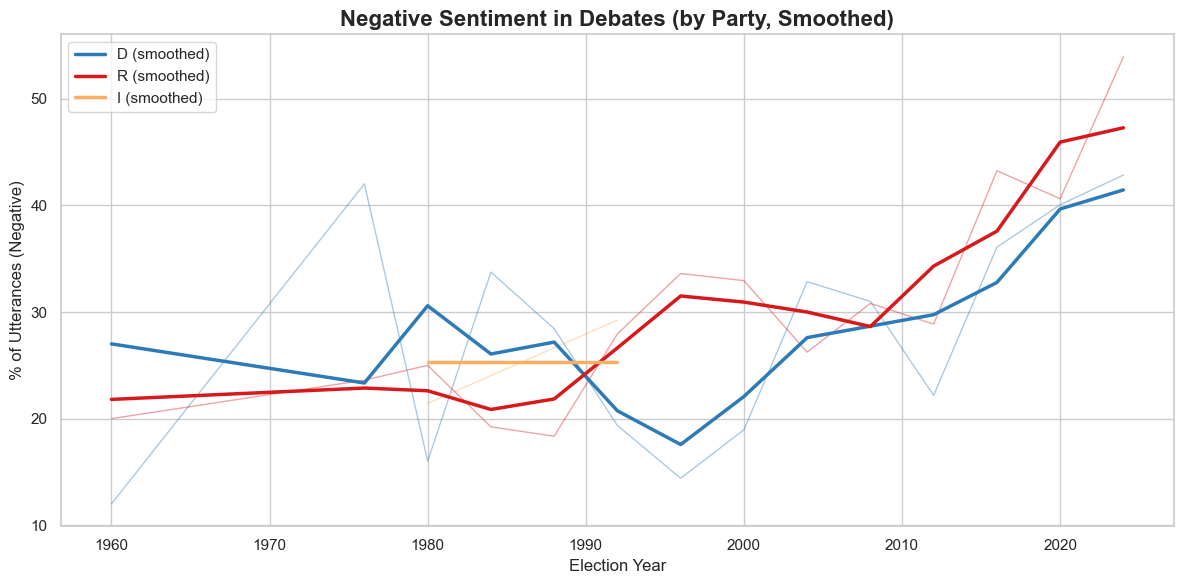

In [94]:
# === LINE PLOT: NEGATIVE SENTIMENT OVER TIME (BY PARTY, SMOOTHED + LIGHT RAW) ===

neg_line = sentiment_share(debates, "negative")

plt.figure(figsize=(12,6))

# raw noisy lines (lighter)
sns.lineplot(
    data=neg_line,
    x="year", y="pct",
    hue="party_code", palette=party_palette,
    linewidth=1, alpha=0.4, legend=False
)

# smoothed bold lines
for party, color in party_palette.items():
    party_data = neg_line[neg_line["party_code"] == party].sort_values("year")
    party_data["smoothed"] = (
        party_data["pct"].rolling(3, center=True, min_periods=1).mean()
    )
    plt.plot(
        party_data["year"], party_data["smoothed"],
        color=color, linewidth=2.5, label=f"{party} (smoothed)"
    )

plt.title("Negative Sentiment in Debates (by Party, Smoothed)", fontsize=16, fontweight="bold")
plt.ylabel("% of Utterances (Negative)")
plt.xlabel("Election Year")
plt.legend()
plt.tight_layout()
plt.show()

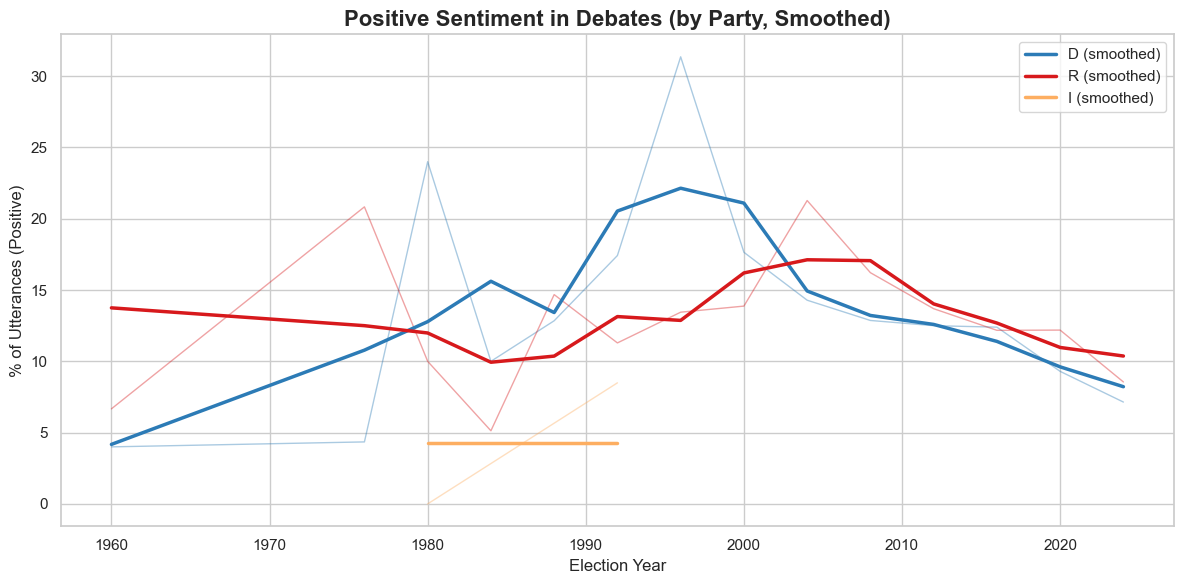

In [95]:
# === LINE PLOT: POSITIVE SENTIMENT OVER TIME (BY PARTY, SMOOTHED + LIGHT RAW) ===

pos_line = sentiment_share(debates, "positive")

plt.figure(figsize=(12,6))

# raw noisy lines (lighter)
sns.lineplot(
    data=pos_line,
    x="year", y="pct",
    hue="party_code", palette=party_palette,
    linewidth=1, alpha=0.4, legend=False
)

# smoothed bold lines
for party, color in party_palette.items():
    party_data = pos_line[pos_line["party_code"] == party].sort_values("year")
    party_data["smoothed"] = (
        party_data["pct"].rolling(3, center=True, min_periods=1).mean()
    )
    plt.plot(
        party_data["year"], party_data["smoothed"],
        color=color, linewidth=2.5, label=f"{party} (smoothed)"
    )

plt.title("Positive Sentiment in Debates (by Party, Smoothed)", fontsize=16, fontweight="bold")
plt.ylabel("% of Utterances (Positive)")
plt.xlabel("Election Year")
plt.legend()
plt.tight_layout()
plt.show()

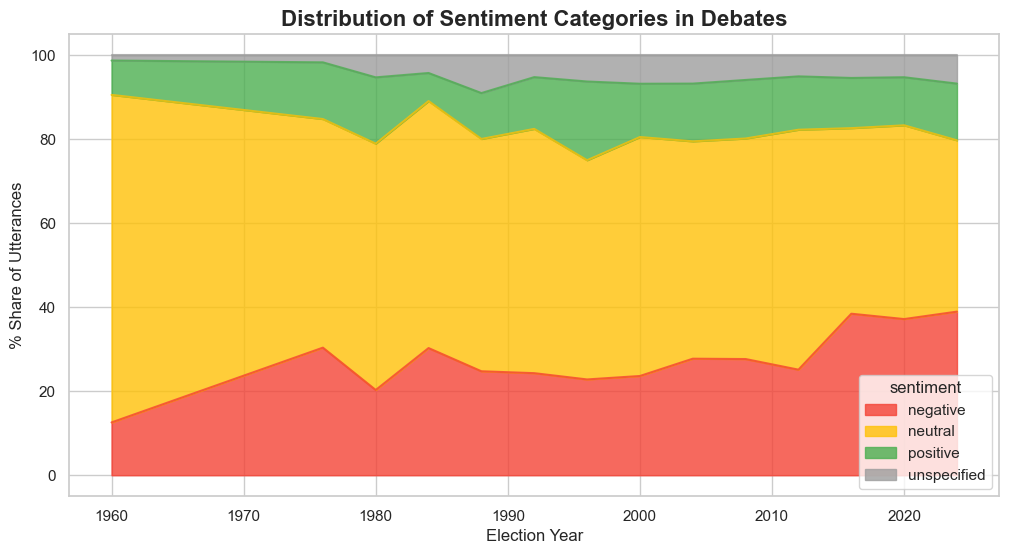

In [92]:
# === STACKED AREA: SENTIMENT DISTRIBUTION OVER TIME ===

sent_dist = (
    debates.groupby(["year","sentiment"])
    .size()
    .reset_index(name="count")
)
totals = sent_dist.groupby("year")["count"].transform("sum")
sent_dist["pct"] = sent_dist["count"] / totals * 100

sent_pivot = sent_dist.pivot(index="year", columns="sentiment", values="pct").fillna(0)

# custom sentiment colors
sentiment_palette = {
    "positive": "#4CAF50",  # green
    "neutral": "#FFC107",   # yellow
    "negative": "#F44336"   # red
}

sent_pivot.plot.area(
    figsize=(12,6), alpha=0.8,
    color=[sentiment_palette.get(col, "#9E9E9E") for col in sent_pivot.columns]
)

plt.title("Distribution of Sentiment Categories in Debates", fontsize=16, fontweight="bold")
plt.ylabel("% Share of Utterances")
plt.xlabel("Election Year")
plt.show()

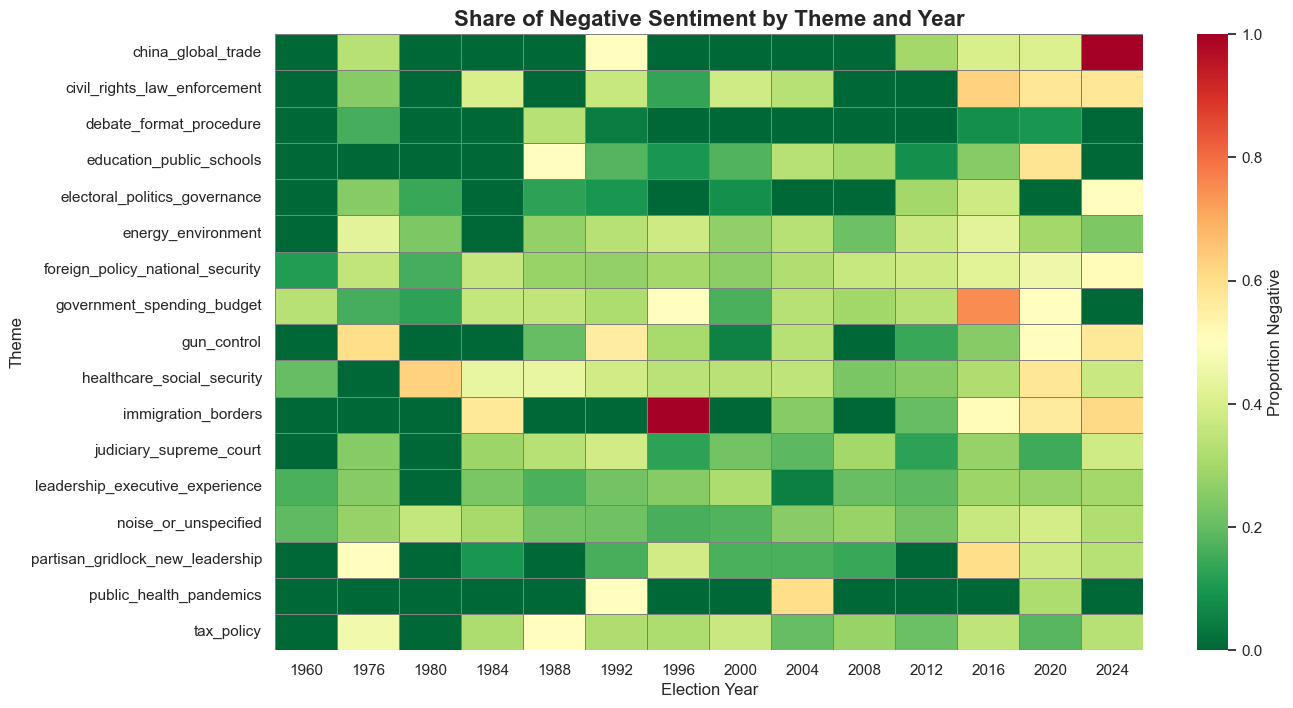

In [104]:
# === HEATMAP: AVERAGE NEGATIVE SHARE PER THEME ===

# compute % negative per theme-year
neg_share = (
    debates.assign(is_negative=debates["sentiment"]=="negative")
    .groupby(["theme","year"])["is_negative"]
    .mean()
    .reset_index()
    .pivot(index="theme", columns="year", values="is_negative")
    .fillna(0)
)

plt.figure(figsize=(14,8))
sns.heatmap(
    neg_share, cmap="RdYlGn_r", center=0.5,
    linewidths=0.5, linecolor="gray",
    cbar_kws={"label": "Proportion Negative"}
)
plt.title("Share of Negative Sentiment by Theme and Year", fontsize=16, fontweight="bold")
plt.xlabel("Election Year")
plt.ylabel("Theme")
plt.show()

### 2.2. Emotions Over Time (Debates)

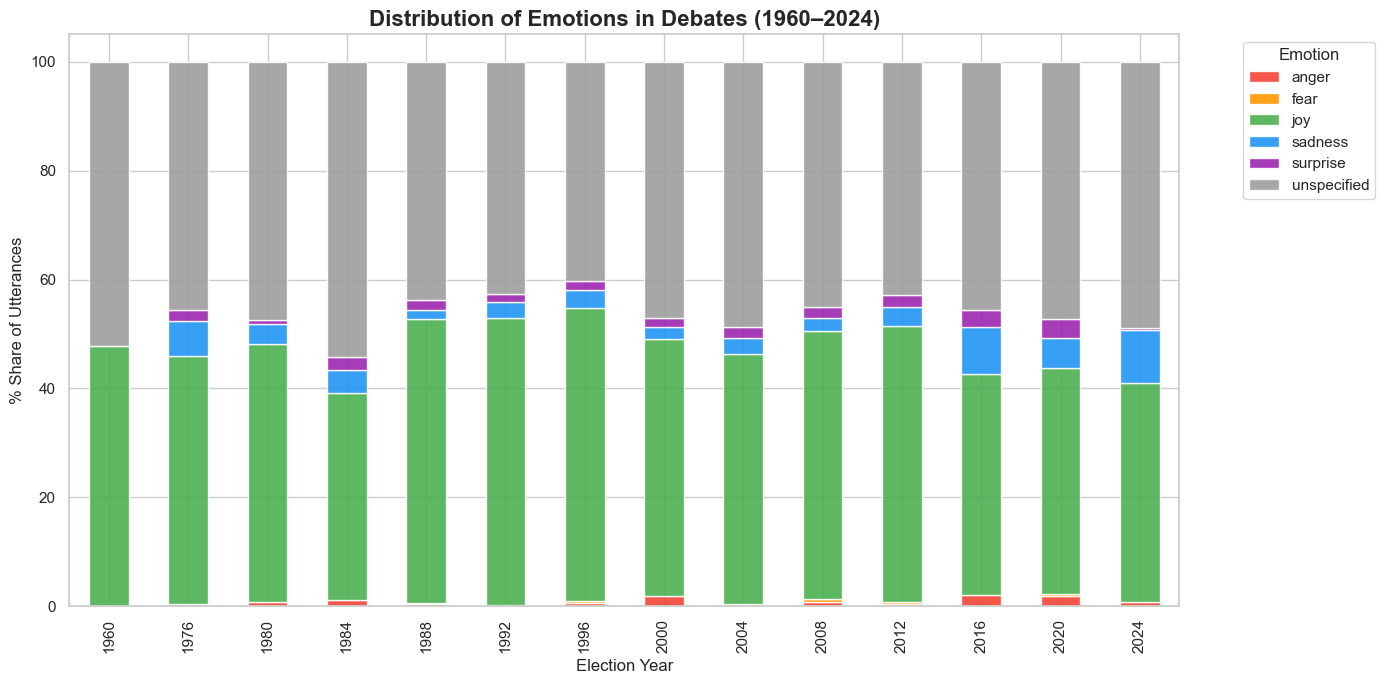

In [99]:
# === STACKED BARS: EMOTION DISTRIBUTION PER CYCLE (CLEAN COLORS) ===

# compute distribution
emo_dist = (
    debates.groupby(["year","emotion"])
    .size()
    .reset_index(name="count")
)
totals = emo_dist.groupby("year")["count"].transform("sum")
emo_dist["pct"] = emo_dist["count"] / totals * 100

emo_pivot = emo_dist.pivot(index="year", columns="emotion", values="pct").fillna(0)

# consistent emotion palette
emotion_palette = {
    "anger": "#F44336",
    "fear": "#FF9800",
    "joy": "#4CAF50",
    "sadness": "#2196F3",
    "surprise": "#9C27B0",
    "unspecified": "#9E9E9E"
}

# reorder columns for readability
col_order = ["anger","fear","joy","sadness","surprise","unspecified"]
emo_pivot = emo_pivot.reindex(columns=col_order)

emo_pivot.plot(
    kind="bar", stacked=True, figsize=(14,7), alpha=0.9,
    color=[emotion_palette[c] for c in emo_pivot.columns]
)

plt.title("Distribution of Emotions in Debates (1960–2024)", fontsize=16, fontweight="bold")
plt.ylabel("% Share of Utterances")
plt.xlabel("Election Year")
plt.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

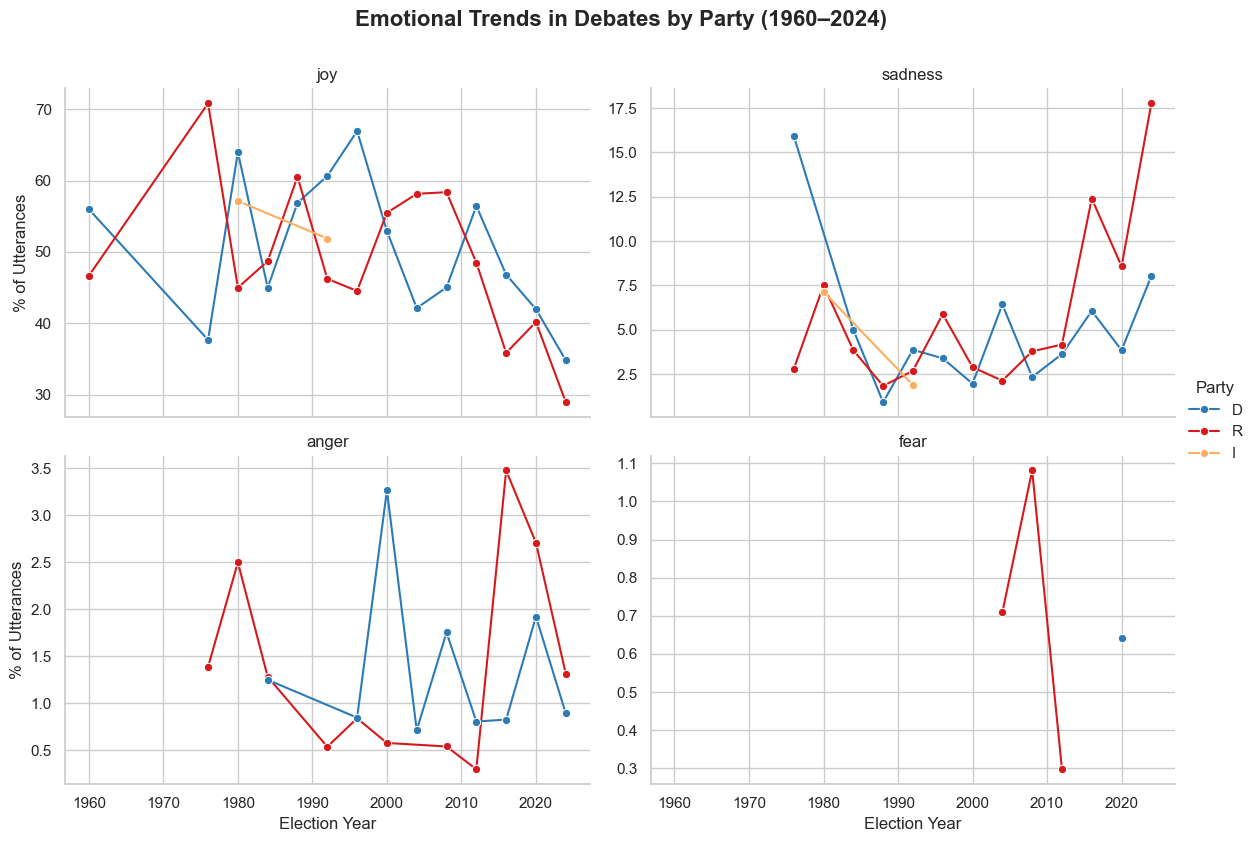

In [100]:
# === TREND LINES: EMOTIONS OVER TIME BY PARTY (FACETTED BY EMOTION) ===

emo_trends = (
    debates.groupby(["year","party_code","emotion"])
    .size()
    .reset_index(name="count")
)
totals = emo_trends.groupby(["year","party_code"])["count"].transform("sum")
emo_trends["pct"] = emo_trends["count"] / totals * 100

# restrict to key emotions
key_emotions = ["anger","joy","fear","sadness"]
emo_subset = emo_trends[emo_trends["emotion"].isin(key_emotions)]

g = sns.FacetGrid(
    emo_subset, col="emotion", col_wrap=2, height=4, aspect=1.5,
    sharey=False
)
g.map_dataframe(
    sns.lineplot,
    x="year", y="pct", hue="party_code",
    palette={"D":"#2C7BB6","R":"#D7191C","I":"#FDAE61"},
    marker="o"
)

g.set_titles("{col_name}")
g.set_axis_labels("Election Year", "% of Utterances")
g.add_legend(title="Party")
plt.suptitle("Emotional Trends in Debates by Party (1960–2024)", fontsize=16, fontweight="bold", y=1.05)
plt.show()

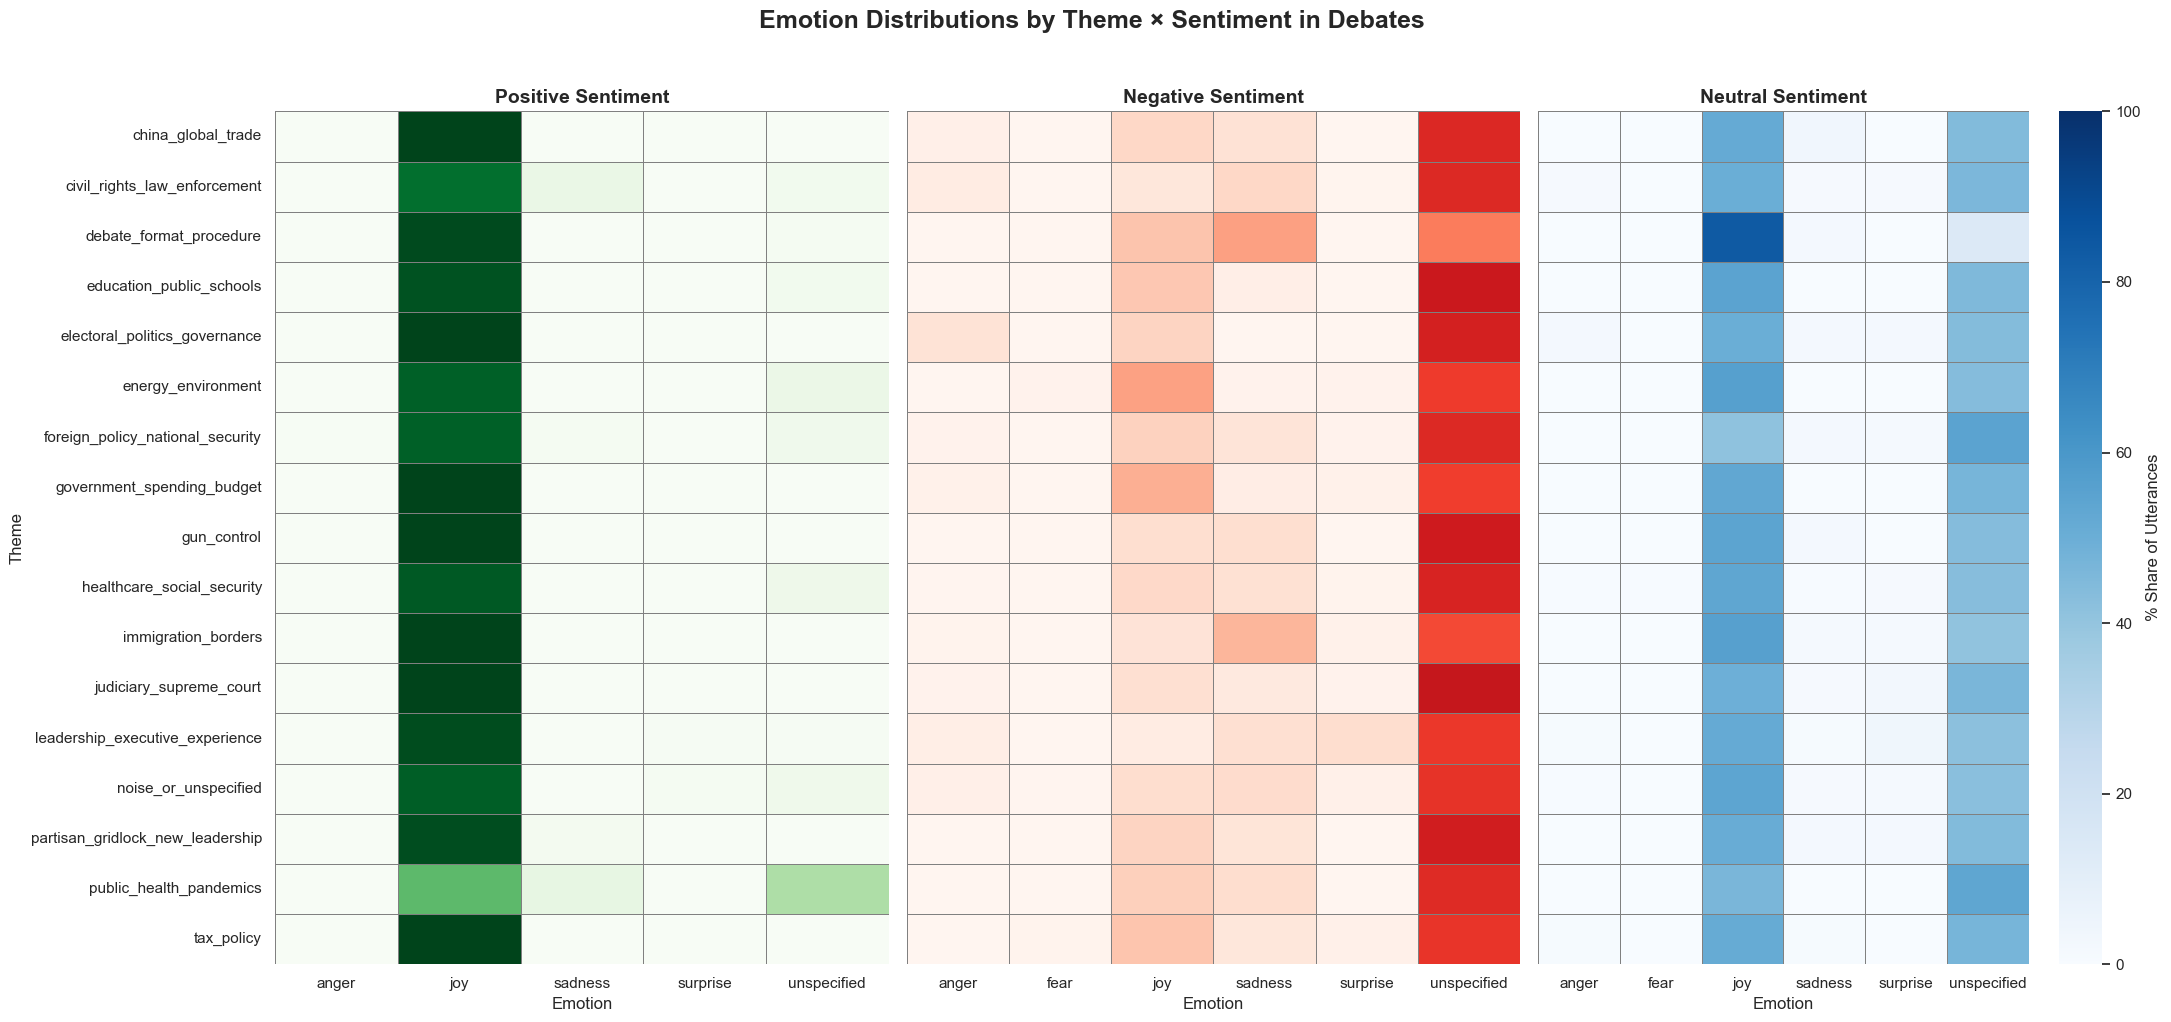

In [103]:
# === THEMES × EMOTIONS × SENTIMENT HEATMAPS ===

import seaborn as sns
import matplotlib.pyplot as plt

# group by theme, sentiment, emotion
emo_sent_theme = (
    debates.groupby(["theme","sentiment","emotion"])
    .size()
    .reset_index(name="count")
)

# normalize within theme × sentiment
totals = emo_sent_theme.groupby(["theme","sentiment"])["count"].transform("sum")
emo_sent_theme["pct"] = emo_sent_theme["count"] / totals * 100

# pivot for heatmap (one per sentiment)
sentiments = ["positive","negative","neutral"]
sentiment_colors = {
    "positive": "Greens",
    "negative": "Reds",
    "neutral": "Blues"
}

fig, axes = plt.subplots(1, len(sentiments), figsize=(22, 10), sharey=True)

for i, sent in enumerate(sentiments):
    subset = emo_sent_theme[emo_sent_theme["sentiment"] == sent]
    heatmap_data = subset.pivot(index="theme", columns="emotion", values="pct").fillna(0)

    sns.heatmap(
        heatmap_data, ax=axes[i],
        cmap=sentiment_colors[sent],
        linewidths=0.5, linecolor="gray",
        vmin=0, vmax=100,
        cbar=(i==len(sentiments)-1),
        cbar_kws={"label": "% Share of Utterances"}
    )
    axes[i].set_title(f"{sent.capitalize()} Sentiment", fontsize=14, fontweight="bold")
    axes[i].set_xlabel("Emotion")
    if i == 0:
        axes[i].set_ylabel("Theme")
    else:
        axes[i].set_ylabel("")

plt.suptitle("Emotion Distributions by Theme × Sentiment in Debates", fontsize=18, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

### 2.3. Media Alignment (2012-2014)

### 2.4. Candidate-Level Spotlight

## 3. Framing and Rhetoric as Political Tools

Step 1. Frames across Time (Debates overall)

Goal: Show how the interpretive “lens” of debates has shifted.

Visualizations:
	1.	Frame prevalence timeline
	•	Line plots of frame share (economic, security, fairness, morality, legality) per decade.
	•	Expect economic consequences dominance early → security spikes post-9/11 → fairness/social justice emerging later.
	2.	Theme × frame heatmap
	•	X = theme (immigration, healthcare, foreign policy, etc.), Y = frame categories, cell color = % share.
	•	Highlights e.g., “Immigration → security,” “Healthcare → economic.”
	3.	New vs old frames
	•	Annotated chart showing when frames appear/disappear.
	•	Example: morality/ethics tied to civil rights in the 1960s, resurging with abortion debates in 2000s.

⸻

Step 2. Partisanship in Framing

Goal: Show that Ds and Rs frame the same issue differently.

Visualizations:
	1.	Sankey diagrams (Theme → Frame)
	•	One for Democrats, one for Republicans.
	•	E.g., immigration: Rs frame as security, Ds as fairness/social justice.
	2.	Stacked bars by party per cycle
	•	% share of frames used by Ds vs Rs over time.
	•	Shows divergence: Rs increasingly “security,” Ds increasingly “fairness.”
	3.	Frame divergence index
	•	JSD between party frame distributions per cycle → line plot.
	•	Quantitative rigor to back up the Sankeys.

⸻

Step 3. Candidate-Level Strategy (Rhetoric + Framing)

Goal: Highlight individual styles, not just party averages.

Visualizations:
	1.	Rhetoric trends (attack/defense/acclaim)
	•	Line plot of % per cycle.
	•	Split by party color → show rise of attack politics.
	2.	Candidate rhetorical fingerprints
	•	Radar/polar charts showing attack/defense/acclaim mix for major candidates (Trump = heavy attack; Obama = acclaim/defense balance).
	3.	Frame × candidate highlights
	•	For a selected candidate (e.g., Trump, Obama, Reagan), stacked bar of frames used.
	•	Storytelling: “Trump framed immigration overwhelmingly as security, while Obama framed healthcare as fairness.”

⸻

Step 4. Media Reflection (2012–2024)

Goal: Do outlets reproduce the frames/rhetoric of debates, or reshape them?

Visualizations:
	1.	Frame distributions by outlet
	•	Bars per cycle: debates vs NYT vs WSJ vs NYP.
	•	Check amplification (NYP pushes security, NYT fairness).
	2.	Theme × frame heatmaps for media vs debates
	•	Compare framing of immigration, healthcare, foreign policy in debates vs each outlet.
	3.	Divergence metrics
	•	Line plot of debate vs outlet frame distributions (JSD per cycle).
	•	Quantifies “mirror” vs “distortion.”


## 4. Is the Political Centre Fading Away?

Step 1. Mapping Ideology Over Time (Debates overall)

Goal: Show the broad trajectory of political discourse in the 2D ideological space.

Visualizations:
	1.	Scatterplot of utterances (econ vs soc)
	•	Color points by decade (gradient from 1960 → 2020).
	•	Add faint density contours to show clusters.
	•	Story: Over time, clouds move away from the center.
	2.	Decade ellipses
	•	Draw confidence ellipses around all utterances in each decade.
	•	Visually highlights drift and expansion into corners of the compass.
	3.	Centroid trajectory plot
	•	One point per decade (centroid of all utterances).
	•	Arrows connecting them → shows “path of ideological movement” across time.

⸻

Step 2. Partisan Polarization in Ideology

Goal: Show Democrats and Republicans pulling apart.

Visualizations:
	1.	Party-colored scatter
	•	Blue = Democrats, Red = Republicans, across all decades.
	•	Add decade ellipses for each party.
	•	Visual collapse of center when ellipses stop overlapping.
	2.	Centroid distance line plot
	•	Y = distance between R & D centroids, X = decade.
	•	Expect steady rise since 1980s.
	3.	Distribution overlap coefficient
	•	Area of overlap between party density distributions → shrinking over time.
	•	Adds rigor to the “center collapse” claim.

⸻

Step 3. Candidate-Level Ideology Profiles

Goal: Make the polarization tangible through individuals.

Visualizations:
	1.	Candidate compass snapshots
	•	Plot candidates individually (Obama, Trump, Reagan, Biden, Sanders).
	•	Each candidate = centroid of their utterances + ellipse of spread.
	•	Compare challengers vs incumbents.
	2.	Party outliers
	•	Identify and annotate the most extreme candidates (Trump authoritarian-right, Sanders libertarian-left).
	•	Adds memorable storytelling.

⸻

Step 4. (Optional) Media Connection

Goal: Show whether media language also clusters ideologically.

Datasets: anchor_theme_alignment.csv
Visualizations:
	•	Anchor-based compass: for “freedom,” “immigration,” etc., plot top theme alignments for debates vs media.
	•	This won’t be as strong quantitatively, but makes a good supporting figure if you want to show that outlets also frame anchors in ways that map to extremes.

⸻

✅ Storytelling Arc
	•	Macro: Debates as a whole drift from center → more extreme over decades.
	•	Partisan: Ds and Rs separate into different corners → overlap disappears.
	•	Micro: Candidates embody this (Trump, Sanders) → extremes more pronounced.
	•	Optional media: Outlets reinforce these extremes with partisan anchor framing.
	•	Punchline: The ideological center is no longer a meeting place but an empty gap.